In [246]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os 
from os.path import join as pjoin
import glob
import numpy as np
import cv2
# from PIL import Image
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
mpl.rcParams['figure.figsize'] = (7, 5)
mpl.rcParams['image.cmap'] = 'inferno'

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def imread(imgpath):
    return cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)

def imshow(img, cmap=None):
    plt.title(img.shape)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
#     plt.show()

def resize(img, shape):
    return cv2.resize(img, (imgshape[1], imgshape[0]))

def stack_images(matrices, k=5, imgshape=np.array([480, 640])):
    """
        matrices -- (N, *imgshape, k) array,
                    where N is the number of `matrices`,
                          k is the number of images in each `matrix`
    """
    k = min(matrices[0].shape[-1], k)
    N = len(matrices)
    num_cols, num_rows = N, 1
    matrices_ = []
    if len(imgshape) == 2:
        for m in matrices:
            M = m.reshape((*imgshape,-1)).transpose(2,0,1)[:k]
            matrices_.append(M)
    else:
        for m in matrices:
            M = m.reshape((*imgshape,-1)).transpose(3,0,1,2)[:k]
            matrices_.append(M)
    for k_ in range(k):
        for i in range(N):
            plt.subplot(num_rows, num_cols, i+1)
            imshow(matrices_[i][k_], 'gray')
        plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# With help of cv2

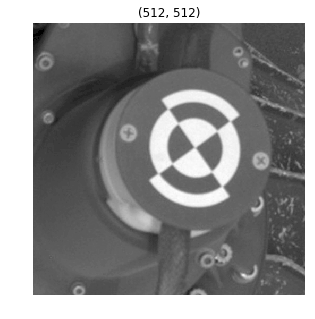

In [247]:
imgdir = 'data'
img_name = 'marker_cut_rgb_512'
# img_name = 'img'
filename = pjoin(imgdir, '{}.png'.format(img_name))

src = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    # Check if image is loaded fine
if src is None:
    print ('Error opening image!')
    print ('Usage: hough_lines.py [image_name -- default ' + default_file + '] \n')

imshow(src, 'gray')

## Edge detection (kernel sobel)

/Users/yevhenp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


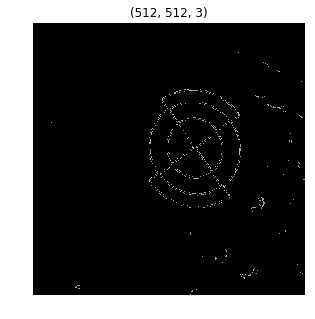

In [248]:
scale = 1
delta = 0
ddepth = cv2.CV_16S

grad_x = cv2.Sobel(src, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(src, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

dst = np.sqrt(grad_x*grad_x + grad_y*grad_y).astype('uint8')
dst[dst < 150] = 0
# imshow(dst, 'gray')
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
imshow(cdst, 'gray')

## After applying Hough space

Number of found lines:  3
<class 'numpy.ndarray'>


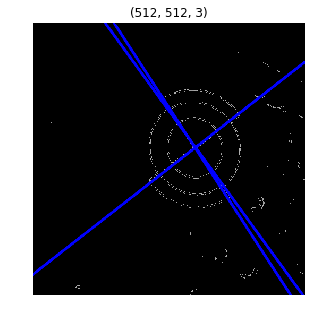

In [249]:
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLines(dst, 1, np.pi / 180, 64, None, 0, 0)

print("Number of found lines: ", len(lines))
print (type(lines))
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
        
imshow(cdst, 'gray')

## Edge detection (Canny) and Hough space

Number of found lines:  3
<class 'numpy.ndarray'>


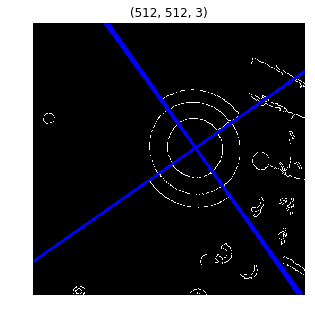

In [250]:
dst = cv2.Canny(src, 50, 200, None, 3)

# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLines(dst, 1, np.pi / 180, 85, None, 0, 0)

print("Number of found lines: ", len(lines))
print (type(lines))
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
        
imshow(cdst, 'gray')


# Custom implementation without cv2 or any other libs

## Edge detection (kernel sobel)

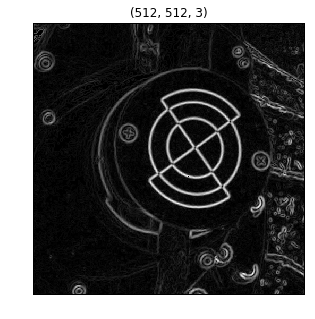

In [263]:
# print(src)
def apply_kernel_sobel(img):

    kernel_x = np.array([[-1, 0, +1],
                         [-2, 0, +2],
                         [-1, 0, +1]])
    
    kernel_y = np.array([[+1, +2, +1],
                         [ 0,  0,  0],
                         [-1, -2, -1]])
    
    width = img.shape[1]
    height = img.shape[0]

    edge = np.zeros_like(img)
    for x in range(1, width - 2):
        for y in range(1, height - 2):
            pixel_x = (kernel_x * img[x-1:x + 2, y-1:y + 2]).sum()
            pixel_y = (kernel_y * img[x-1:x + 2, y-1:y + 2]).sum()

            val = np.sqrt((pixel_x * pixel_x) + (pixel_y * pixel_y)).astype('uint8')
            edge[x,y] = val
            
    return edge

dst = apply_kernel_sobel(src)

cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
# imshow(dst, 'gray')
imshow(cdst, 'gray')
# print(temp)

## After using threshold

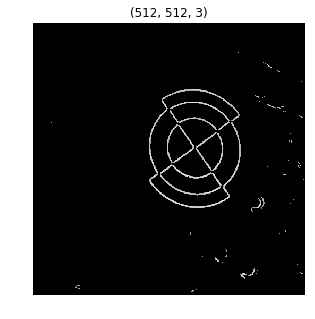

In [264]:
threshold = 150
dst[dst < threshold] = 0

cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
# imshow(dst, 'gray')
imshow(cdst, 'gray')
# print(temp)

## Convert to hough space

In [269]:
def hough_accumulator(img):
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, 2.0))
    width, height = img.shape
    diag_len = np.ceil(np.sqrt(width * width + height * height)).astype('int')   # max_dist
    num_rhos = diag_len * 2
    rhos = np.linspace(-diag_len, diag_len, num_rhos)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    accumulator = np.zeros((num_rhos, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]).astype('int') + diag_len
#             print(rho, diag_len, t_idx)
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

def hough_lines(img, threshold):
    accumulator, thetas, rhos = hough_accumulator(dst)
    acc_idx = np.argwhere(accumulator > threshold)
    lines = np.empty(acc_idx.shape)
    i = 0
    for pair in acc_idx:
        lines[i] = (rhos[pair[0]], thetas[pair[1]])
        i+=1

    return lines
    


In [270]:
lines = hough_lines(img = dst, threshold = 145)

## Show lines on edges

Number of found lines:  3


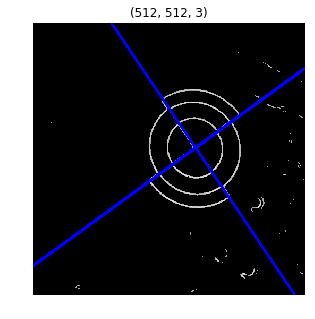

In [271]:
print("Number of found lines: ", len(lines))
for i in range(0, len(lines)):
    rho = lines[i][0]
    theta = lines[i][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(cdst, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
        
imshow(cdst, 'gray')

## Show lines on initial gray image

Number of found lines:  3


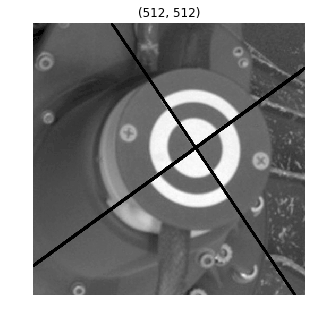

In [274]:
print("Number of found lines: ", len(lines))
for i in range(0, len(lines)):
    rho = lines[i][0]
    theta = lines[i][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(src, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
        
imshow(src, 'gray')